In [17]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Path of the optimal racing line (.npy file)
fpath = "./racelines/reinvent_base-1500-8-2024-04-03-150434.npy"

# Change manually (this is only so that output files are named correctly)
TRACK_NAME = "ReInvent-Base"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
racing_track = racing_track.tolist()[:-1]

In [19]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

In [20]:
LOOK_AHEAD_POINTS = 5
MIN_SPEED = 1.3
MAX_SPEED = 4

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track, 
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed: 2.1339149383506864


Constant multiple for optimal speed: 2.1339149383506864


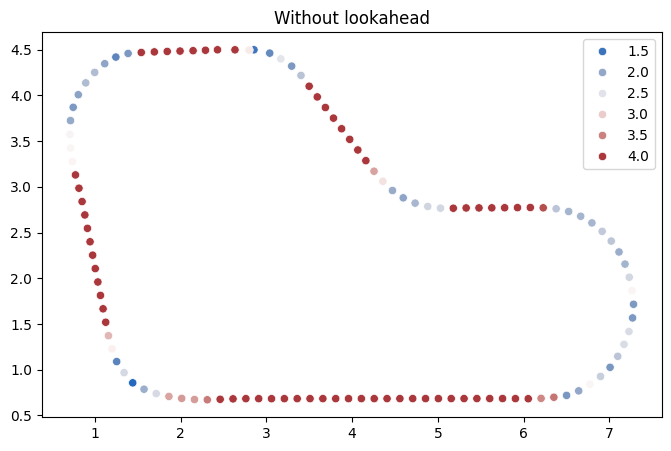

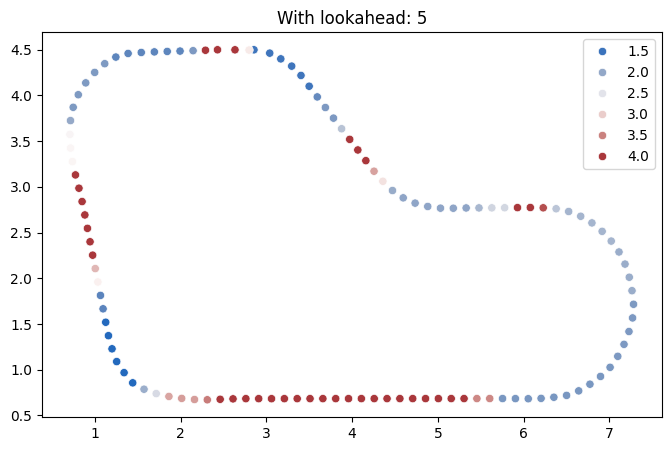

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

In [22]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)
    
time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 7.660680383452049 s


In [23]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

In [24]:
# Write to txt file
with open(f'optimals_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")